# Stack Overflow Survey 2017 Analysis

## Topics of Interest to be Analyzed
Based on the given Stack Overflow Survey 2017 (https://www.kaggle.com/datasets/stackoverflow/so-survey-2017/code?datasetId=1406&searchQuery=udacity) which allows a brief "look into the lives of over 64,000 Stack Overflow developers" I want to analyze the following topics:

* (1) What are the most commonly mentioned languages that participants have already worked with and want to work with? Is there a intention to other languages visible?
* (2) Have Worked Language vs. Salary: What is the statistical relation of the mentioned languages the respondents have worked with and their salary? Does the language statistically have influence on the income and if yes, what kind of influence?
* (3) Developer Type vs. Salary: What is the statistical relation of the mentioned developer type to income. Which types of developer have higher incomes, which have lower incomes?

In [2]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

In [3]:
# Number of rows to display of dataframe
pd.set_option('display.max_rows', 40)

## Theoretical Approach to Determine the Most Influential Variables on 'Salary'

**Situation:**

"survey-results-public.csv" has more than 150 variables mixed of ordinal, nominal and absolute scale.

**Theoretical Approach:**

* Data Preprocessing
    * Handle Missing Values
    * Encode Categorical Values
* Feature Selection
    * Correlation Matrix (only for numerical features)
    * Chi-Square Test (only for categorical/nominal values)
    * Feature Importance from Maschine Learning Models (dg. Random Forest, Gradient Boosting)
* Recursive Feature Elimination (RFE)
* Principal Component Analysis (PCA)
  

## Gathering Data

### Raw Data Sample

In [4]:
df = pd.read_csv('./survey-results-public.csv')
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
Respondent,1,2,3,4,5,6,7,8,9,10
Professional,Student,Student,Professional developer,Professional non-developer who sometimes write...,Professional developer,Student,Professional non-developer who sometimes write...,Professional developer,Professional developer,Professional developer
ProgramHobby,"Yes, both","Yes, both","Yes, both","Yes, both","Yes, I program as a hobby","Yes, both","Yes, both","Yes, both","Yes, I program as a hobby","Yes, I program as a hobby"
Country,United States,United Kingdom,United Kingdom,United States,Switzerland,New Zealand,United States,Poland,Colombia,France
University,No,"Yes, full-time",No,No,No,"Yes, full-time",No,No,"Yes, part-time","Yes, full-time"
...,...,...,...,...,...,...,...,...,...,...
QuestionsInteresting,Strongly agree,Somewhat agree,Agree,Agree,NaN,Agree,Agree,Somewhat agree,Strongly agree,Agree
QuestionsConfusing,Disagree,Disagree,Disagree,Somewhat agree,NaN,Disagree,Disagree,Disagree,Disagree,Disagree
InterestedAnswers,Strongly agree,Strongly agree,Agree,Strongly agree,NaN,Agree,Agree,Agree,Strongly agree,Agree
Salary,NaN,NaN,113750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51392 entries, 0 to 51391
Data columns (total 154 columns):
 #    Column                            Non-Null Count  Dtype  
---   ------                            --------------  -----  
 0    Respondent                        51392 non-null  int64  
 1    Professional                      51392 non-null  object 
 2    ProgramHobby                      51392 non-null  object 
 3    Country                           51392 non-null  object 
 4    University                        51392 non-null  object 
 5    EmploymentStatus                  51392 non-null  object 
 6    FormalEducation                   51392 non-null  object 
 7    MajorUndergrad                    42841 non-null  object 
 8    HomeRemote                        44008 non-null  object 
 9    CompanySize                       38922 non-null  object 
 10   CompanyType                       38823 non-null  object 
 11   YearsProgram                      51145 non-null  ob

## Assessing Data

### Analysis of Population of Columns

#### Analysis of Columns Related to Missing Values

In [6]:
def non_nan_barh(df, collist):
    ''' 
    Create horizontal bar graph diagram for the population ratio (non NaN-ratio) of a given dataframe.
    
    INPUT
    df - pandas dataframe 
    collist - Python list with column names to be included in diagram; empty list []: include all columns of dataframe
    '''   
    
      # Calculate the non-NaN value ratio for each column
    if not collist:
        # Empty column list
        non_nan_ratio = df.notna().mean()
    else:
        # Column list is not empty - more focussed bar graph diagram just for columns in reseach_columns_all list
        non_nan_ratio = df[collist].notna().mean()

    nnr_index = non_nan_ratio.index
    non_nan_ratio = non_nan_ratio.iloc[::-1]
        
    # Create a horizontal bar graph
    plt.figure(figsize=(10, len(non_nan_ratio)*0.25))
    bars = non_nan_ratio.plot(kind='barh')  # Change to horizontal bar graph
    plt.title('Non-NaN Value Ratio for Each Column')
    plt.xlabel('Non-NaN Ratio')
    plt.ylabel('Columns')
    plt.xlim(0, 1)  # Set x-axis limits
    plt.grid(axis='x')

    # Add value labels to each bar
    for index, value in enumerate(non_nan_ratio):
        plt.text(value, index, f'{value:.2%}', va='center')

    plt.show()

    return

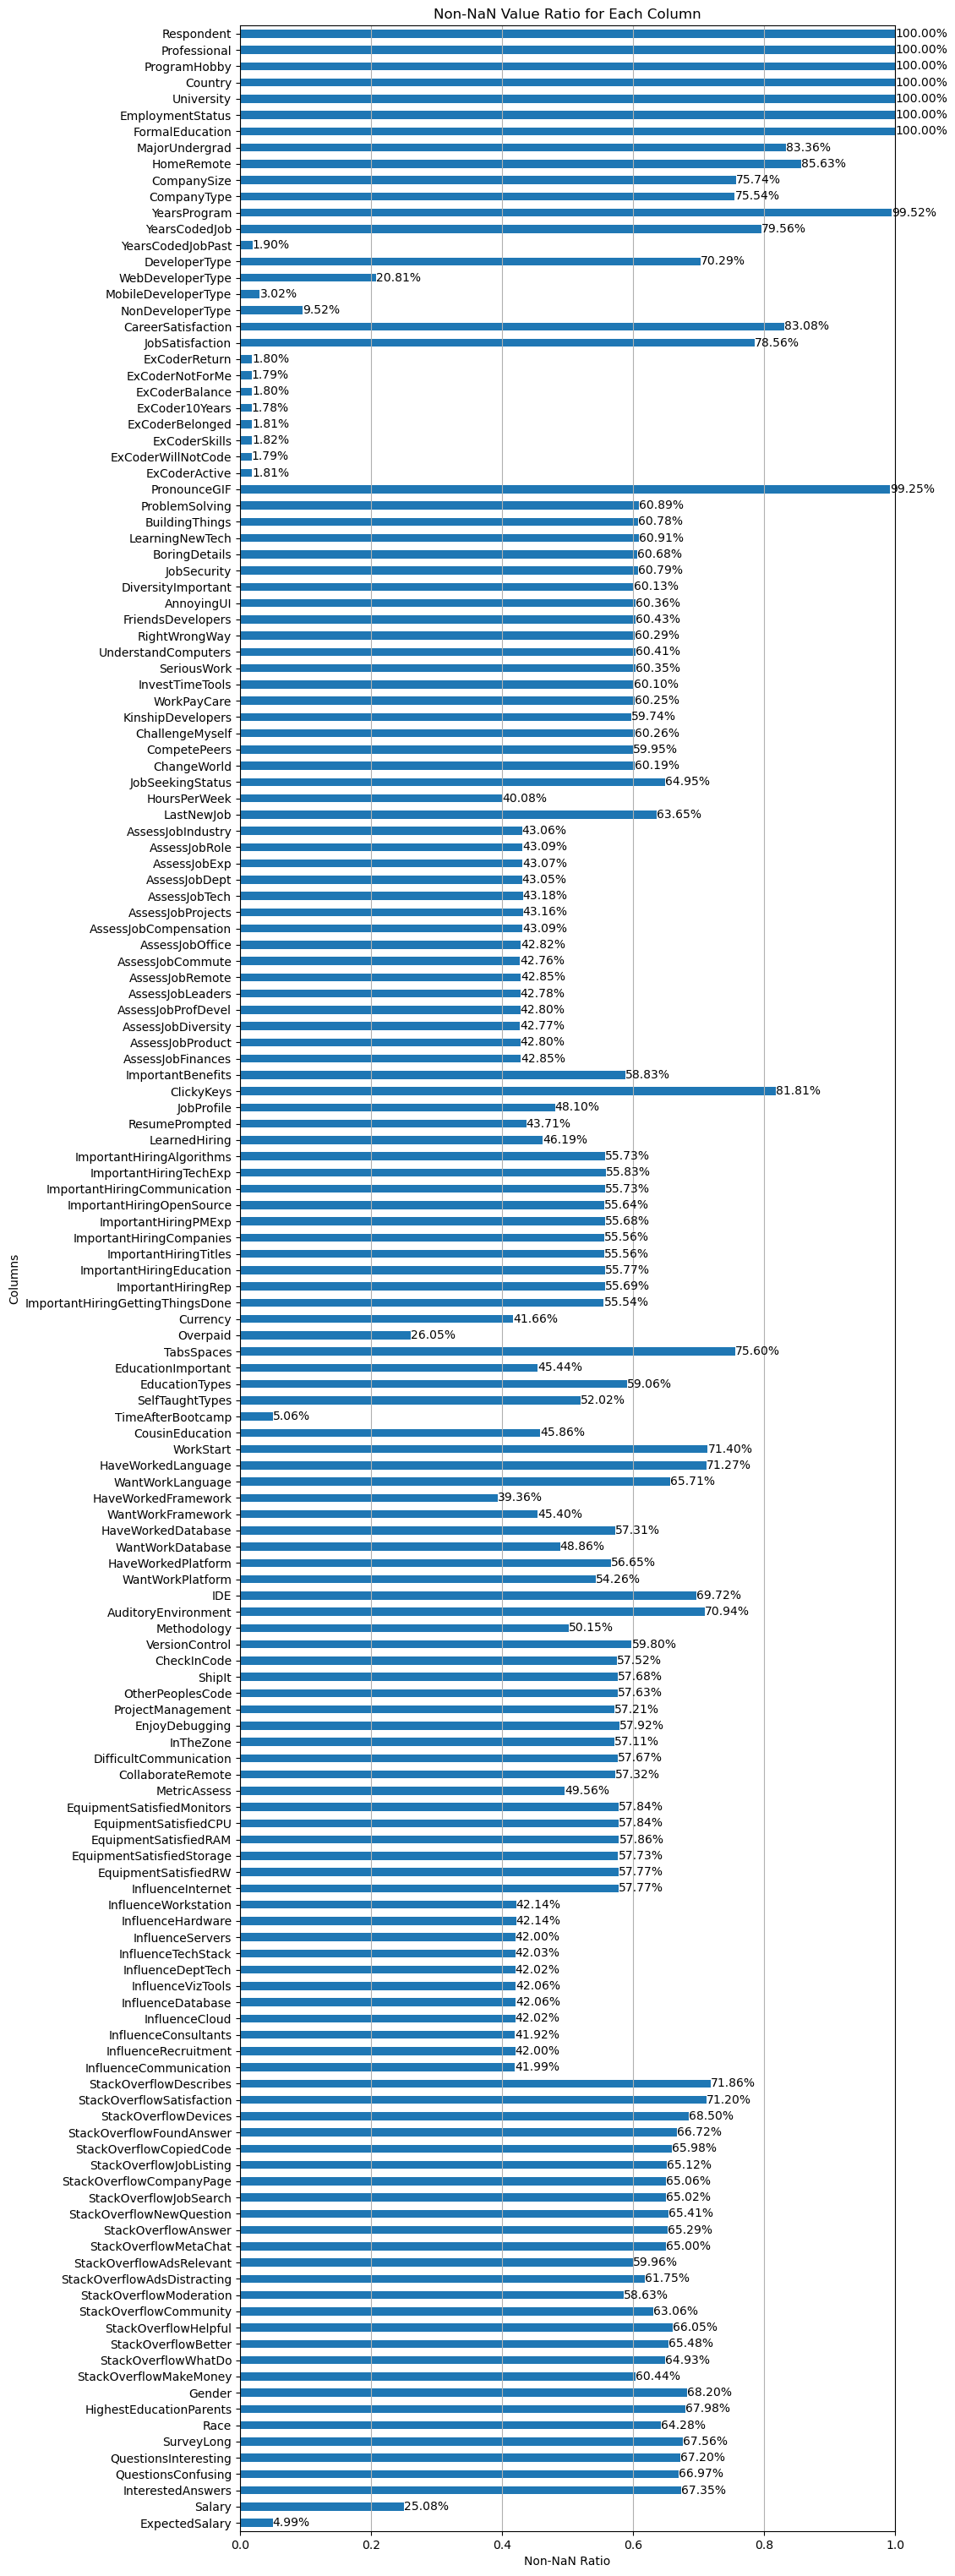

In [7]:
non_nan_barh(df, [])

**The bar chart above shows, that**
* **first seven columns do not have any missing value**
* **there many columns well populated (not NaN percentage above 50%)**
* **some columns are poorly populated**
* **The target feature 'SALARY' has a population rate of 25%**

#### Analysis of Column Values of Columns with Datatype 'object'

In [8]:
pd.set_option('display.max_colwidth', None)

df_colvals_object = pd.DataFrame(columns = ['Column', 'Unique Values'])

# Identify columns of datatype 'object
lst_object_cols = df.select_dtypes(include=['object']).columns.tolist()

# Check unique values in each column of type object
for col in lst_object_cols:
    unique_values = df[col].unique()
    # print(f"{col} - unique values in column:\n {unique_values}")
    df_row = pd.DataFrame(data = {'Column': col, 'Unique Values': [str(list(unique_values))]})
    
    df_colvals_object = pd.concat([df_colvals_object, df_row], ignore_index=True)

df_colvals_object

Column  \
0            Professional   
1            ProgramHobby   
2                 Country   
3              University   
4        EmploymentStatus   
..                    ...   
142                  Race   
143            SurveyLong   
144  QuestionsInteresting   
145    QuestionsConfusing   
146     InterestedAnswers   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

**This analysis shows, that there are**
* **many nominal scaled columns (like 'Country', 'Professional' etc.)**
* **many ordinal scaled columns (like 'CompanySize', 'YearsProgram'), some of them numerically coded (like 'CareerStatisfaction')**
* **some columns with nested ordinal columns (like 'HaveWorkdLanguage', 'WantWorkLanguage') which require special treatment.**

## (1) HaveWorkLanguage and WantWorkLanguage Mentions (on Entire DataSet)

**This analysis is done by using the entire dataset.**

In [9]:
def count_nested_val(df, col, sep):
    ''' 
    Split up nested cell values separated by sep in dataframe df in column col and count the number of occurrences of all values
    
    INPUT
    df - pandas dataframe 
    col - Column name within dataframe
    sep - separator literal
    
    OUTPUT
    df_result - Series with single values and overall count of occurrence within column col in dataframe df
    '''   
    # Fill NaN values with an empty string to avoid TypeError
    df[col] = df[col].fillna('')

    # Split the values in the column into separate elements and strip spaces into lists in a list split_values
    split_values = df[col].str.split(sep).apply(lambda x: [item.strip() for item in x if item.strip()])  # Also filter out empty strings
    
    # Flatten the list of lists into a single list
    flattened_values = [item for sublist in split_values for item in sublist]
    
    # Count the occurrences of each value
    value_counts = Counter(flattened_values)
    
    # Convert to DataFrame for better readability
    df_result = pd.DataFrame(value_counts.items(), columns=[col, 'Count']).sort_values(by='Count', ascending=False)
    return df_result

In [10]:
def top_n_pie_chart(df, catcol, countcol, top_n):
    ''' 
    Create a pie chart diagram containing the top n values and aggregating the remaining values to "Others"
    
    INPUT
    df - pandas dataframe 
    catcol - column, which contains the category values
    countcol - column, which contains the counts (numerical)
    top_n - top N values having its own pie segment
    '''   
    
    # Top 10 languages
    top_10 = df.nlargest(top_n, countcol)
    
    # Sum for "Others"
    others = pd.DataFrame([{catcol: 'Others', countcol: df['Count'][top_n:].sum()}])
    
    # Combine top 10 with "Others"
    final_df = pd.concat([top_10, others], ignore_index=True)
    
    # Plot pie chart
    plt.figure(figsize=(10, 7))
    plt.pie(final_df[countcol], labels=final_df[catcol], autopct='%1.1f%%', startangle=140)
    plt.title(f'Top 10 of {catcol} and Others')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

In [11]:
df_HaveWorkedLanguage = count_nested_val(df, 'HaveWorkedLanguage', ';')
df_HaveWorkedLanguage

,HaveWorkedLanguage,Count
1,JavaScript,22875
4,SQL,18754
5,Java,14524
15,C#,12476
2,Python,11704
6,PHP,10290
18,C++,8155
17,C,6974
24,TypeScript,3488
3,Ruby,3324


## (1) HaveWorkLanguage - Visualization

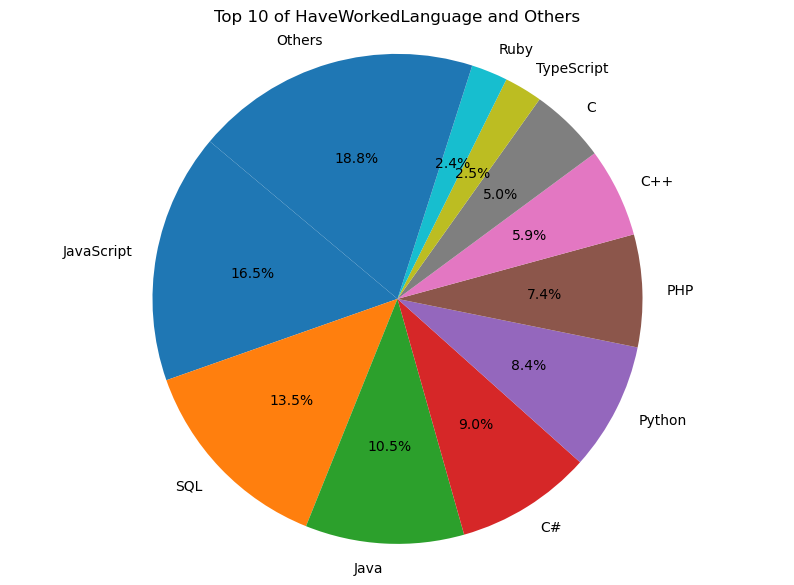

In [12]:
top_n_pie_chart(df_HaveWorkedLanguage, 'HaveWorkedLanguage', 'Count', 10)

In [13]:
df_WantWorkLanguage = count_nested_val(df, 'WantWorkLanguage', ';')
df_WantWorkLanguage

,WantWorkLanguage,Count
14,JavaScript,16327
2,Python,12570
4,SQL,11217
19,C#,10187
1,Java,9988
22,C++,7647
18,Go,5770
13,TypeScript,5692
26,PHP,5365
5,C,4841


## (1) WantWorkLanguage - Visualization

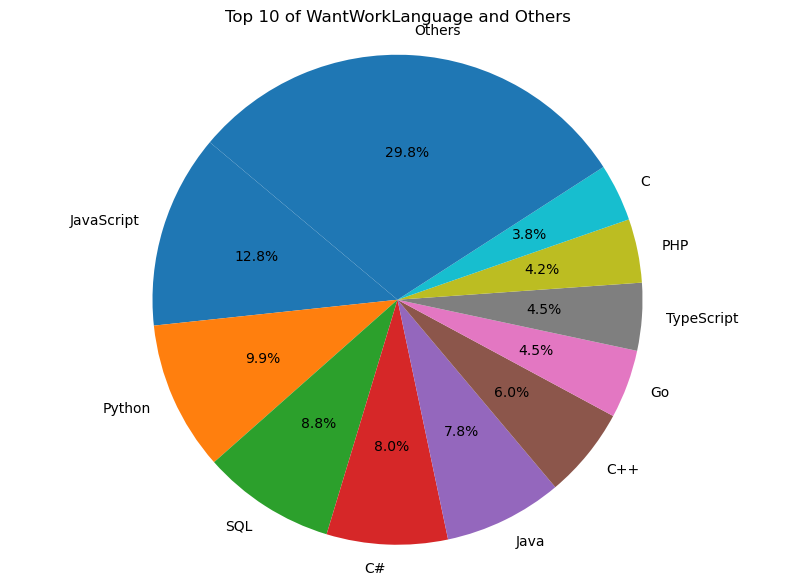

In [14]:
top_n_pie_chart(df_WantWorkLanguage, 'WantWorkLanguage', 'Count', 10)

**The analysis shows, that the top 5 mentioned Have-Worked-Languages are JavaScript, SQL, Java, C# followed by Python. The share of other languages with lower shares than the top 10 is around 19%.
Regarding the Want-Work-Languages there is a signifcant change in order - JavaScript, Python, SQL, C# followed by Java. Due to the increase in the share of languages below the top 10 ('Others') from 18.8% to 29.8% in mentions, it seems that there is a high interest in getting more divers in learning and applying various languages (e. g. high increase for Scala and Rust).**

## (2, 3) Salary and Possible Determinating Variables

### Assess Data

#### Analysis of Professional Column

In [15]:
df_professional = count_nested_val(df, 'Professional', ';')
df_professional

,Professional,Count
1,Professional developer,36131
0,Student,8224
2,Professional non-developer who sometimes writes code,5140
3,Used to be a professional developer,983
4,None of these,914


**In order to reduce the noise/bias caused by Non-Professional Developers (especially students) regarding target feature 'Salary', I remove these rows from the dataset, i.e. I keep only rows with Professional = 'Professional Developer'.**

#### Analysis of Salary and Country Column

In [16]:
df_country = count_nested_val(df, 'Country', ';')

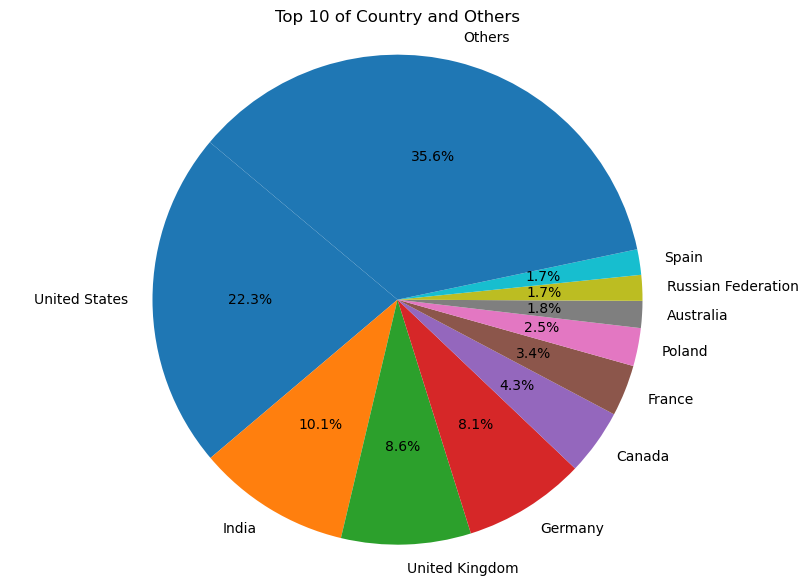

In [17]:
top_n_pie_chart(df_country, 'Country', 'Count', 10)

In [18]:
result = df[df['Professional'] == 'Professional developer'][['Salary', 'Country']].dropna(subset=['Salary']).sort_values(by='Salary', ascending=False)
result

,Salary,Country
31600,197000.0,United States
27943,195000.0,United States
6743,195000.0,United States
18237,195000.0,United States
41398,195000.0,United States
...,...,...
44841,0.0,Japan
23953,0.0,Colombia
51144,0.0,Australia
4517,0.0,India


**As the analysis of country shows, the respondents live in many different countries. My hypothesis is, that** 
* **the salary data might at least sometimes be given in the local currencies of the respondents or**
* **even in case they are converted correctly to one currency - the the international purchasing power difference was not accounted for in the figures**
**so data comparison might be difficult across several countries.**

### Clean Data

#### Reduction of Data Set Related to Questions of Interest

In [19]:
research_columns_all = ['Respondent', 'ProgramHobby', 'CompanySize', 'CompanyType', 'YearsProgram', 'YearsCodedJob', 'DeveloperType', 'HaveWorkedLanguage', 'WantWorkLanguage', 'CareerSatisfaction', 'JobSatisfaction', 'Salary' ]
research_columns_1v = [ 'CareerSatisfaction', 'JobSatisfaction']

#### Analysis of Population Ratio of Columns of Reduced Data Set

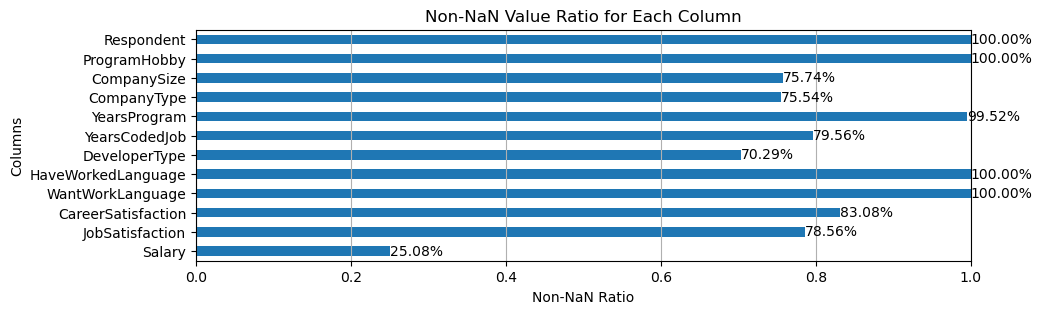

In [20]:
non_nan_barh(df, research_columns_all)

In [21]:
data_types = df[research_columns_all].dtypes
data_types_df = data_types.reset_index()
data_types_df.columns = ['Column', 'Data Type']
print(data_types_df)

                Column Data Type
0           Respondent     int64
1         ProgramHobby    object
2          CompanySize    object
3          CompanyType    object
4         YearsProgram    object
5        YearsCodedJob    object
6        DeveloperType    object
7   HaveWorkedLanguage    object
8     WantWorkLanguage    object
9   CareerSatisfaction   float64
10     JobSatisfaction   float64
11              Salary   float64


**Related to my research questions of salary I will focus on the following data:**
* **In order to rule out obvious bias from different professional types, I focus this analysis on Professinal = 'Professional developer'**
* **In order to rule out currency conversion or international purchasing power issues I limit my further investigation to responses from Country = 'United States'**
* **In order to rule out obvious bias from non-full-time working employees, I limit my investigation to EmploymentStatus = 'Employed full-time' or 'Independent contractor, freelancer, or self-employed'.**

In [22]:
# Create a reduced copy of the overall df dataframe for further analysis related to Salary
# Limit rows to Professional Developers, Country = United States, EmploymentStatus = Employed Full-Time, or Contractor, Freelander, Self-Employed
# in order to reduce noise/bias related to target feature Salary
df_red = df[(df['Professional'] == 'Professional developer') 
                & (df['Country'] == 'United States') 
                & ((df['EmploymentStatus'] == 'Employed full-time') 
                   |(df['EmploymentStatus'] == 'Independent contractor, freelancer, or self-employed'))][research_columns_all].copy() 


In [23]:
df_red.head(8).T

,15,17,18,25,27,39,44,49
Respondent,16,18,19,26,28,40,45,50
ProgramHobby,"Yes, I program as a hobby","Yes, both","Yes, I program as a hobby","Yes, I program as a hobby","Yes, I program as a hobby","Yes, I program as a hobby","Yes, I program as a hobby","Yes, I program as a hobby"
CompanySize,NaN,"1,000 to 4,999 employees","10,000 or more employees","10,000 or more employees",100 to 499 employees,I don't know,"10,000 or more employees",NaN
CompanyType,NaN,Publicly-traded corporation,Publicly-traded corporation,Publicly-traded corporation,Venture-funded startup,Publicly-traded corporation,"Privately-held limited company, not in startup mode",NaN
YearsProgram,11 to 12 years,20 or more years,2 to 3 years,20 or more years,2 to 3 years,20 or more years,20 or more years,20 or more years
YearsCodedJob,1 to 2 years,20 or more years,3 to 4 years,16 to 17 years,Less than a year,5 to 6 years,10 to 11 years,20 or more years
DeveloperType,Desktop applications developer,Web developer; Embedded applications/devices developer; DevOps specialist; Quality assurance engineer; Other,Web developer,Web developer,Web developer; Desktop applications developer,Desktop applications developer,Web developer; Developer with a statistics or mathematics background; Desktop applications developer,Web developer; Mobile developer
HaveWorkedLanguage,JavaScript; VB.NET,C; Clojure; JavaScript; Matlab; Rust; SQL; Swift,,Java; Scala,,,Java; JavaScript; SQL; VBA,C#; Java; SQL
WantWorkLanguage,C#; F#; JavaScript; R; VB.NET,Assembly; Clojure; Go; JavaScript; Rust; Swift; TypeScript,,JavaScript; Scala,,,Clojure; Groovy; JavaScript; Scala,F#; Go; TypeScript
CareerSatisfaction,8.0,9.0,5.0,7.0,9.0,9.0,5.0,9.0


In [24]:
df_red.shape

(7952, 12)

#### Analysis of Population Ratio of Rows of Reduced Data Set

In [25]:
# Calculate the ratio of not-null values for each row
df_red_notnan_ratio = df_red.apply(lambda row: (len(row)-row.isnull().sum()) / len(row), axis=1)

In [26]:
# Calculate the ratio of null values for each row
df_red_nan_ratio = 1 - df_red_notnan_ratio

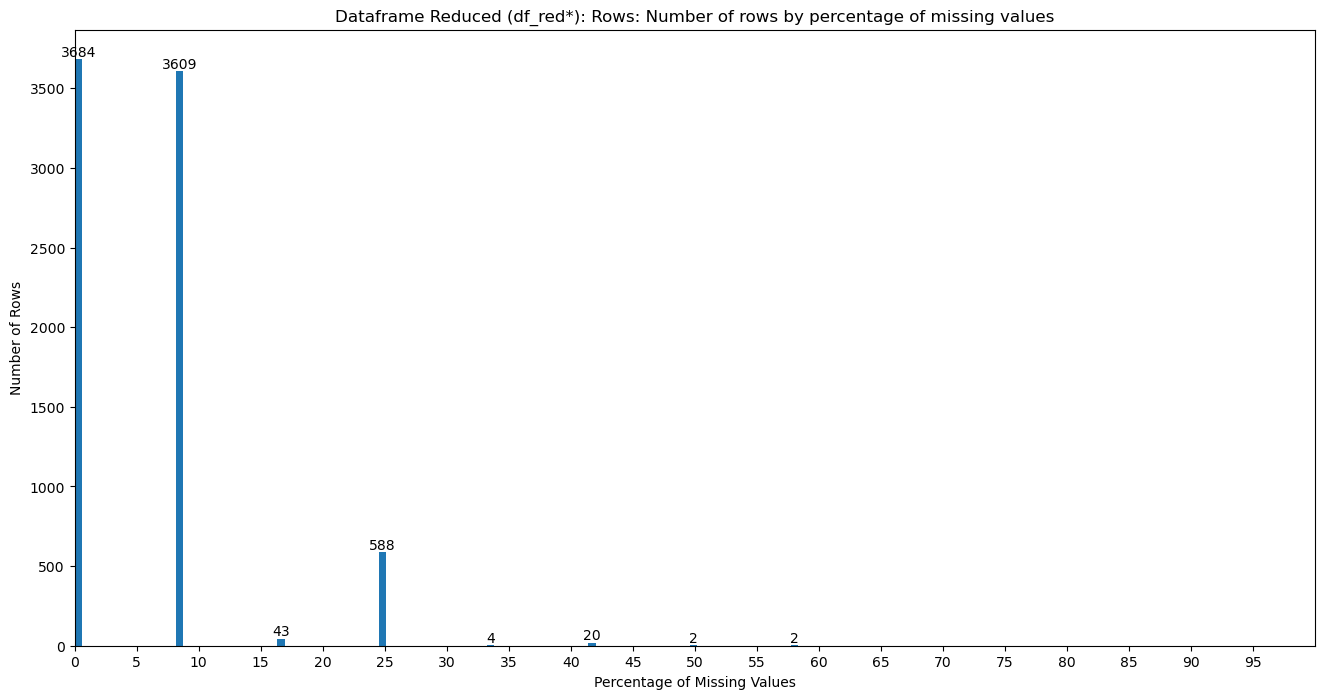

In [27]:
### import matplotlib.pyplot as plt
### import matplotlib.ticker as ticker

# Sample DataFrame for demonstration (replace this with your actual DataFrame)
# df_red_nan_ratio = pd.DataFrame({'missing_values_ratio': np.random.rand(1000)})  # Example DataFrame

plt.figure(figsize=(16, 8))
counts, bins, patches = plt.hist(df_red_nan_ratio * 100, bins=100)

plt.xticks(np.arange(0, 100, 5))
plt.ylabel('Number of Rows')
plt.xlabel('Percentage of Missing Values')
plt.title('Dataframe Reduced (df_red*): Rows: Number of rows by percentage of missing values')
plt.xlim(0, 100)

# Add y-value annotations for bins with counts > 0
for count, x in zip(counts, bins):
    if count > 0:
        # Calculate the position to place the text
        plt.text(x + (bins[1] - bins[0]) / 2, count, int(count), 
                 ha='center', va='bottom')  # ha: horizontal alignment, va: vertical alignment

plt.show()

In [28]:
# Sort the values for visualization
df_red_notnan_ratio_reindexed = df_red_notnan_ratio.sort_values(ascending=False).reset_index(drop=True)

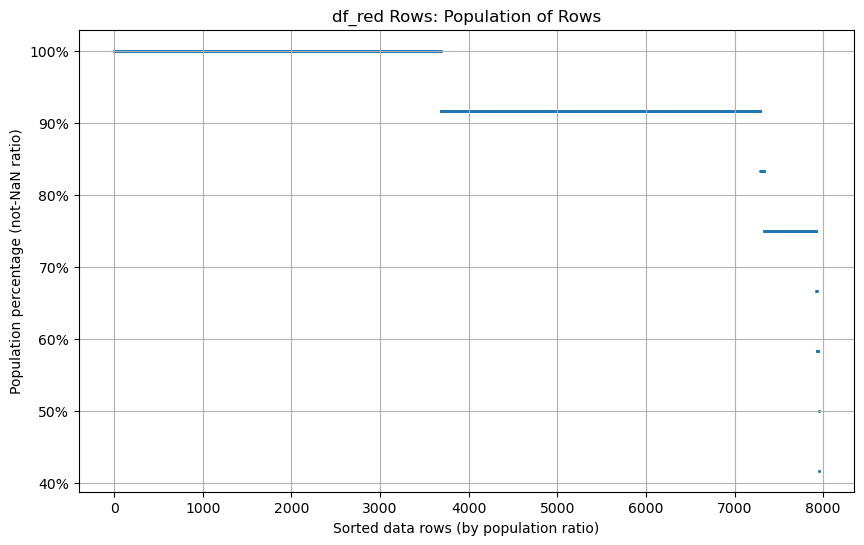

In [29]:
perc = np.linspace(0, 100)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df_red_notnan_ratio_reindexed.index, df_red_notnan_ratio_reindexed, label='df_red_notnan_ratio_reindexed', s=1)

# Format the y-axis as percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

# plt.scatter(gendemo_notnan_ratio_reindexed.index, gendemo_notnan_ratio_reindexed, label='gendemo_notnan_ratio_reindexed', s=1)
plt.title('df_red Rows: Population of Rows')
plt.xlabel('Sorted data rows (by population ratio)')
plt.ylabel('Population percentage (not-NaN ratio)')
plt.grid(True)  
plt.show()

**Result:** **In the columnwise-reduced dataset df_red are 3684 rows, without any Null value. Hence the these rows are being kept for further analysis. The remaining rows (containing one ore more Null values) are removed.**

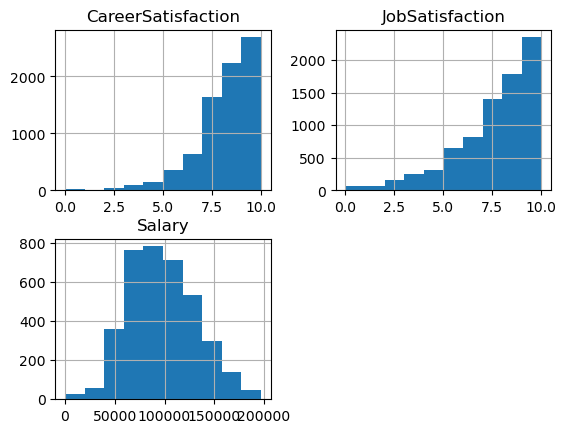

In [30]:
df_red[['CareerSatisfaction', 'JobSatisfaction', 'Salary']].hist();

In [31]:
# Remove rows containing any NULL value from df_red
df_red.dropna(axis=0, how='any', inplace=True)

df_red.head(5).T

,17,18,25,70,72
Respondent,18,19,26,71,73
ProgramHobby,"Yes, both","Yes, I program as a hobby","Yes, I program as a hobby","Yes, I program as a hobby","Yes, both"
CompanySize,"1,000 to 4,999 employees","10,000 or more employees","10,000 or more employees",20 to 99 employees,100 to 499 employees
CompanyType,Publicly-traded corporation,Publicly-traded corporation,Publicly-traded corporation,"Privately-held limited company, not in startup mode",Venture-funded startup
YearsProgram,20 or more years,2 to 3 years,20 or more years,2 to 3 years,20 or more years
YearsCodedJob,20 or more years,3 to 4 years,16 to 17 years,1 to 2 years,20 or more years
DeveloperType,Web developer; Embedded applications/devices developer; DevOps specialist; Quality assurance engineer; Other,Web developer,Web developer,Web developer,Web developer
HaveWorkedLanguage,C; Clojure; JavaScript; Matlab; Rust; SQL; Swift,,Java; Scala,CoffeeScript; JavaScript; Ruby,C#; JavaScript; SQL
WantWorkLanguage,Assembly; Clojure; Go; JavaScript; Rust; Swift; TypeScript,,JavaScript; Scala,Elixir; JavaScript,C#; F#; JavaScript; Python; Rust; TypeScript
CareerSatisfaction,9.0,5.0,7.0,8.0,8.0


In [32]:
# Confirmation, that no column contains any Null value anymore (sum == 0)
df_red.isna().sum()

Respondent            0
ProgramHobby          0
CompanySize           0
CompanyType           0
YearsProgram          0
YearsCodedJob         0
DeveloperType         0
HaveWorkedLanguage    0
WantWorkLanguage      0
CareerSatisfaction    0
JobSatisfaction       0
Salary                0
dtype: int64

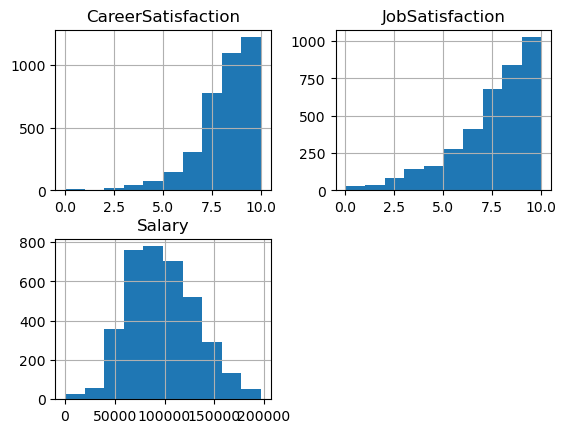

In [33]:
df_red[['CareerSatisfaction', 'JobSatisfaction', 'Salary']].hist();

**Visual comparison of value distribution before and after deletion of rows containing Null values, confirms that rough proporations are still kept.**

### Preprocess/cleanse ordinal scaled features 
* CompanySize
* YearsProgram
* YearsCodedJob

In [34]:
def recode_ord_to_int(df, dict_map, map_valcol, map_colnameint):
    ''' 
    Recode ordinal values of column map_valcol in dataframe df using dict_map as mapping table. Original column is dropped.
    
    INPUT
    df - pandas dataframe 
    dict_map - dictionary with two "lists" (original value list needs to be named "index")
    map_valcol - Name of original column in input dataframe df
    map_colnameint - Name of list in dictionary containing mapped int values

    OUTPUT
    df - pandas dataframe with mapped value
    '''      

    df_map = pd.DataFrame(dict_map)
    df_map.set_index('index', inplace=True)

    # Force Int64 value type for map_colnameint (i.e. result column)
    df_map[map_colnameint] = df_map[map_colnameint].astype('Int64')
    
    df = df.merge(df_map, left_on=map_valcol, right_index=True, how='inner')

    # Remove obsolete old column
    df = df.drop([map_valcol], axis=1)
    return df

#### Recode CompanySize (Ordinal Scale)

In [35]:
mapCompanySize = {
        'index': ['Fewer than 10 employees', '10 to 19 employees', 
                  '20 to 99 employees', '100 to 499 employees', 
                  '500 to 999 employees', '1,000 to 4,999 employees',
                  '5,000 to 9,999 employees', '10,000 or more employees',
                  "I don't know", 'I prefer not to answer'],
        'CompanySizeInt': [5, 15,
                 60, 300,
                 750, 3000,
                 7500, 17500,
                np.NaN, np.NaN] }
df_red = recode_ord_to_int(df_red, mapCompanySize, 'CompanySize', 'CompanySizeInt')


#### Recode YearsProgram (Ordinal Scale)

In [36]:
mapYearsProgram = {
        'index': ['Less than a year', '1 to 2 years', '2 to 3 years', '3 to 4 years', 
                   '4 to 5 years', '5 to 6 years', '6 to 7 years', '7 to 8 years',
                   '8 to 9 years',  '9 to 10 years',  '10 to 11 years', '11 to 12 years', 
                   '12 to 13 years', '13 to 14 years', '14 to 15 years', '15 to 16 years', 
                   '16 to 17 years', '17 to 18 years', '18 to 19 years', '19 to 20 years', 
                   '20 or more years'],
        'YearsProgramInt': [1, 2, 3, 4,
                            5, 6, 7, 8,
                            9, 10, 11, 12,
                            13, 14, 15, 16, 
                            17, 18, 19, 20, 
                            25]}
df_red = recode_ord_to_int(df_red, mapYearsProgram, 'YearsProgram', 'YearsProgramInt')


#### Recode YearsCodedJob (Ordinal Scale)

In [37]:
mapYearsCodedJob = {
        'index': ['Less than a year', '1 to 2 years', '2 to 3 years', '3 to 4 years', 
                   '4 to 5 years', '5 to 6 years', '6 to 7 years', '7 to 8 years',
                   '8 to 9 years',  '9 to 10 years',  '10 to 11 years', '11 to 12 years', 
                   '12 to 13 years', '13 to 14 years', '14 to 15 years', '15 to 16 years', 
                   '16 to 17 years', '17 to 18 years', '18 to 19 years', '19 to 20 years', 
                   '20 or more years'],
        'YearsCodedJobInt': [1, 2, 3, 4,
                            5, 6, 7, 8,
                            9, 10, 11, 12,
                            13, 14, 15, 16, 
                            17, 18, 19, 20, 
                            25]}
df_red = recode_ord_to_int(df_red, mapYearsCodedJob, 'YearsCodedJob', 'YearsCodedJobInt')


In [38]:
df_red.head(10).T

,17,18,25,70,72,76,81,99,103,115
Respondent,18,19,26,71,73,77,82,100,104,116
ProgramHobby,"Yes, both","Yes, I program as a hobby","Yes, I program as a hobby","Yes, I program as a hobby","Yes, both","Yes, both","Yes, I program as a hobby","Yes, both",No,"Yes, I contribute to open source projects"
CompanyType,Publicly-traded corporation,Publicly-traded corporation,Publicly-traded corporation,"Privately-held limited company, not in startup mode",Venture-funded startup,Government agency or public school/university,"Sole proprietorship or partnership, not in startup mode","Privately-held limited company, not in startup mode","Privately-held limited company, not in startup mode","Privately-held limited company, not in startup mode"
DeveloperType,Web developer; Embedded applications/devices developer; DevOps specialist; Quality assurance engineer; Other,Web developer,Web developer,Web developer,Web developer,Web developer,Web developer,Mobile developer; Desktop applications developer,Web developer,Web developer
HaveWorkedLanguage,C; Clojure; JavaScript; Matlab; Rust; SQL; Swift,,Java; Scala,CoffeeScript; JavaScript; Ruby,C#; JavaScript; SQL,C#; JavaScript,Java; SQL,C; Go; Objective-C; Ruby; Swift,Python,C#; JavaScript
WantWorkLanguage,Assembly; Clojure; Go; JavaScript; Rust; Swift; TypeScript,,JavaScript; Scala,Elixir; JavaScript,C#; F#; JavaScript; Python; Rust; TypeScript,C#,Groovy; Java; Smalltalk; SQL,C; Go; Haskell; Objective-C; Ruby; Rust; Swift,JavaScript,C#; F#; JavaScript
CareerSatisfaction,9.0,5.0,7.0,8.0,8.0,10.0,7.0,8.0,10.0,8.0
JobSatisfaction,8.0,3.0,7.0,5.0,5.0,8.0,6.0,8.0,10.0,8.0
Salary,130000.0,82500.0,175000.0,65000.0,120000.0,96283.0,110000.0,109400.0,51000.0,90000.0
CompanySizeInt,3000,17500,17500,60,300,3000,60,60,60,15


#### One-hot Encode Remaining Nominal Variables (CompanyType)

In [39]:
# One-hot encode the CompanyType column
df_red = pd.get_dummies(df_red, columns=['CompanyType', 'ProgramHobby'], dummy_na=True, dtype=int)

In [40]:
# Normalize value using Sklearn MinMaxScaler
scaler = MinMaxScaler()  # default=(0, 1)
numerical = ['CareerSatisfaction', 'JobSatisfaction', 'YearsProgramInt', 'YearsCodedJobInt', 'Salary']

# Fit and transform the numerical columns
df_red[numerical] = scaler.fit_transform(df_red[numerical])

# Now df_red contains the scaled numerical columns along with the original non-numerical columns
df_red.head()

,Respondent,DeveloperType,HaveWorkedLanguage,WantWorkLanguage,CareerSatisfaction,JobSatisfaction,Salary,CompanySizeInt,YearsProgramInt,YearsCodedJobInt,...,"CompanyType_Sole proprietorship or partnership, not in startup mode",CompanyType_Something else,CompanyType_State-owned company,CompanyType_Venture-funded startup,CompanyType_nan,ProgramHobby_No,"ProgramHobby_Yes, I contribute to open source projects","ProgramHobby_Yes, I program as a hobby","ProgramHobby_Yes, both",ProgramHobby_nan
17,18,Web developer; Embedded applications/devices developer; DevOps specialist; Quality assurance engineer; Other,C; Clojure; JavaScript; Matlab; Rust; SQL; Swift,Assembly; Clojure; Go; JavaScript; Rust; Swift; TypeScript,0.9,0.8,0.659890,3000,1.000000,1.000000,...,0,0,0,0,0,0,0,0,1,0
18,19,Web developer,,,0.5,0.3,0.418767,17500,0.083333,0.125000,...,0,0,0,0,0,0,0,1,0,0
25,26,Web developer,Java; Scala,JavaScript; Scala,0.7,0.7,0.888322,17500,1.000000,0.666667,...,0,0,0,0,0,0,0,1,0,0
70,71,Web developer,CoffeeScript; JavaScript; Ruby,Elixir; JavaScript,0.8,0.5,0.329932,60,0.083333,0.041667,...,0,0,0,0,0,0,0,1,0,0
72,73,Web developer,C#; JavaScript; SQL,C#; F#; JavaScript; Python; Rust; TypeScript,0.8,0.5,0.609127,300,1.000000,1.000000,...,0,0,0,1,0,0,0,0,1,0


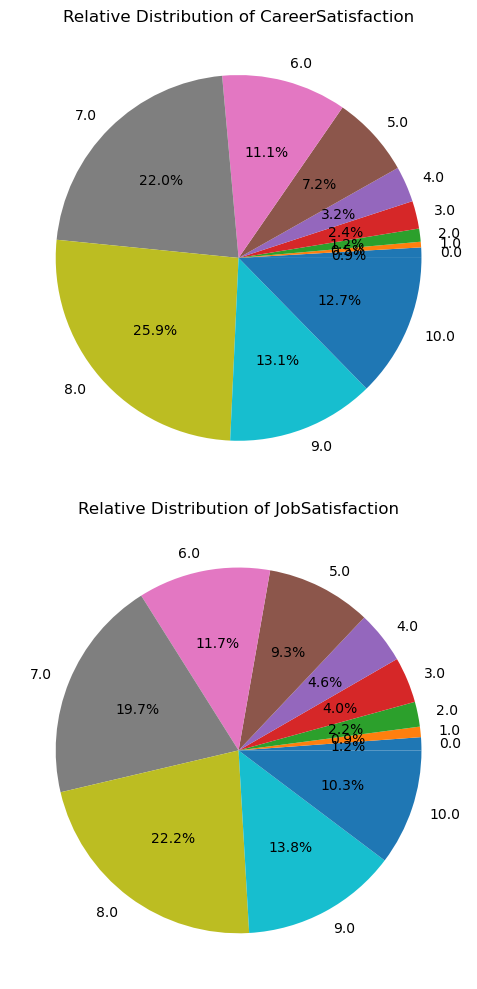

In [41]:
def plot_categorical_distributions(df, collist):
    ''' 
    Create series of bar chart diagrams to show distriution of categorial column values in individual columns
    
    INPUT
    df - pandas dataframe 
    collist - Python list with column names to be included in subplots
    '''   
    num_cols = len(collist)
    fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(10, 5 * num_cols))
    
    if num_cols == 1:
        axes = [axes]

    for ax, col in zip(axes, collist):
        value_counts = df[col].value_counts(normalize=True).sort_index()
        ax.pie(value_counts.values, labels=value_counts.index.astype(str), autopct='%1.1f%%')
        ax.set_title(f'Relative Distribution of {col}')
    
    plt.tight_layout()
    plt.show()

plot_categorical_distributions(df, research_columns_1v)

In [42]:
def get_dummies_nested(df, col, sep, prefix):
    ''' 
    Split up nested cell values separated by sep in dataframe df in column col and one-hot encode it (i. e. to new columns).
    
    INPUT
    df - pandas dataframe 
    col - Column name within dataframe
    sep - separator literal
    prefix - prefix for new columns in order to document the relation to origin column

    OUTPUT
    df - Enhanced dataframe with newly created columns for each value in unique nested value in the column col
    '''   

    # Iterate across all column values of col
    # Create set of mentioned values in column across all rows; assure that leading and trailing spaces are removed; 
    colvals = set([])        # Set with values of existing in origin columns
    colnames = set([])       # Set with prefixed column names, into which the values are split up
   
    for val in df[col]:  
        if type(val) is not float:
            colvals = colvals.union(set([item.strip() for item in val.split(";")]))
            colnames = colnames.union(set([prefix+item.strip() for item in val.split(";")]))
    
    lst_colvals = list(colvals)
    lst_colnames = list(colnames)
    lst_colvals.sort()
    lst_colnames.sort()
    
    # Create new columns bases on list lst_colnames
    df = df.reindex(columns = df.columns.tolist() + lst_colnames)
    # Set all newly created cells to False
    df[lst_colnames] = False

    # Re-iterate across all column values of col
    # Split up items named in col as True value of specific colname
    
    for index, val in df[col].items():
        if type(val) is not float:
            # Derive column names of columns to update from nested value
            lst_colstrue = [prefix+item.strip() for item in val.split(";")] 
            # Update df in respective columns in current row
            df.loc[index, lst_colstrue] = True

    # Remove obsolete old column
    df = df.drop([col], axis=1)
    
    return df

In [43]:
df_red = get_dummies_nested(df_red, 'HaveWorkedLanguage', ';', 'HWL_')
df_red = get_dummies_nested(df_red, 'WantWorkLanguage', ';', 'WWL_')
df_red = get_dummies_nested(df_red, 'DeveloperType', ';', 'DEVT_')
df_red.head(10).T

,17,18,25,70,72,76,81,99,103,115
Respondent,18,19,26,71,73,77,82,100,104,116
CareerSatisfaction,0.9,0.5,0.7,0.8,0.8,1.0,0.7,0.8,1.0,0.8
JobSatisfaction,0.8,0.3,0.7,0.5,0.5,0.8,0.6,0.8,1.0,0.8
Salary,0.65989,0.418767,0.888322,0.329932,0.609127,0.488733,0.558364,0.555319,0.258864,0.456839
CompanySizeInt,3000,17500,17500,60,300,3000,60,60,60,15
...,...,...,...,...,...,...,...,...,...,...
DEVT_Mobile developer,False,False,False,False,False,False,False,True,False,False
DEVT_Other,True,False,False,False,False,False,False,False,False,False
DEVT_Quality assurance engineer,True,False,False,False,False,False,False,False,False,False
DEVT_Systems administrator,False,False,False,False,False,False,False,False,False,False


#### Correlation of CareerSatisfaction / JobSatisfaction to Salary

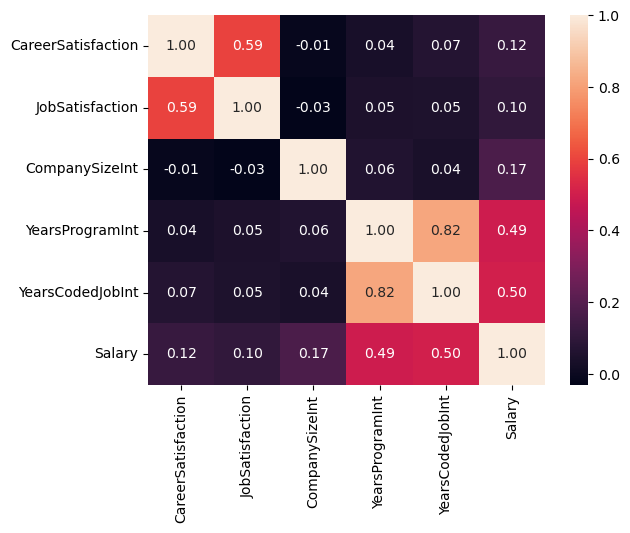

In [44]:
sns.heatmap(df_red[['CareerSatisfaction', 'JobSatisfaction', 'CompanySizeInt', 'YearsProgramInt', 'YearsCodedJobInt', 'Salary']].corr(), annot=True, fmt=".2f");

**There is a positive correlation between JobSatisfaction and Salary (+0.10) and even stronger between CareerSatisfaction and Salary (+0.12). The correlation between YearsProgram/YearsCodedJob is arround 0.5**

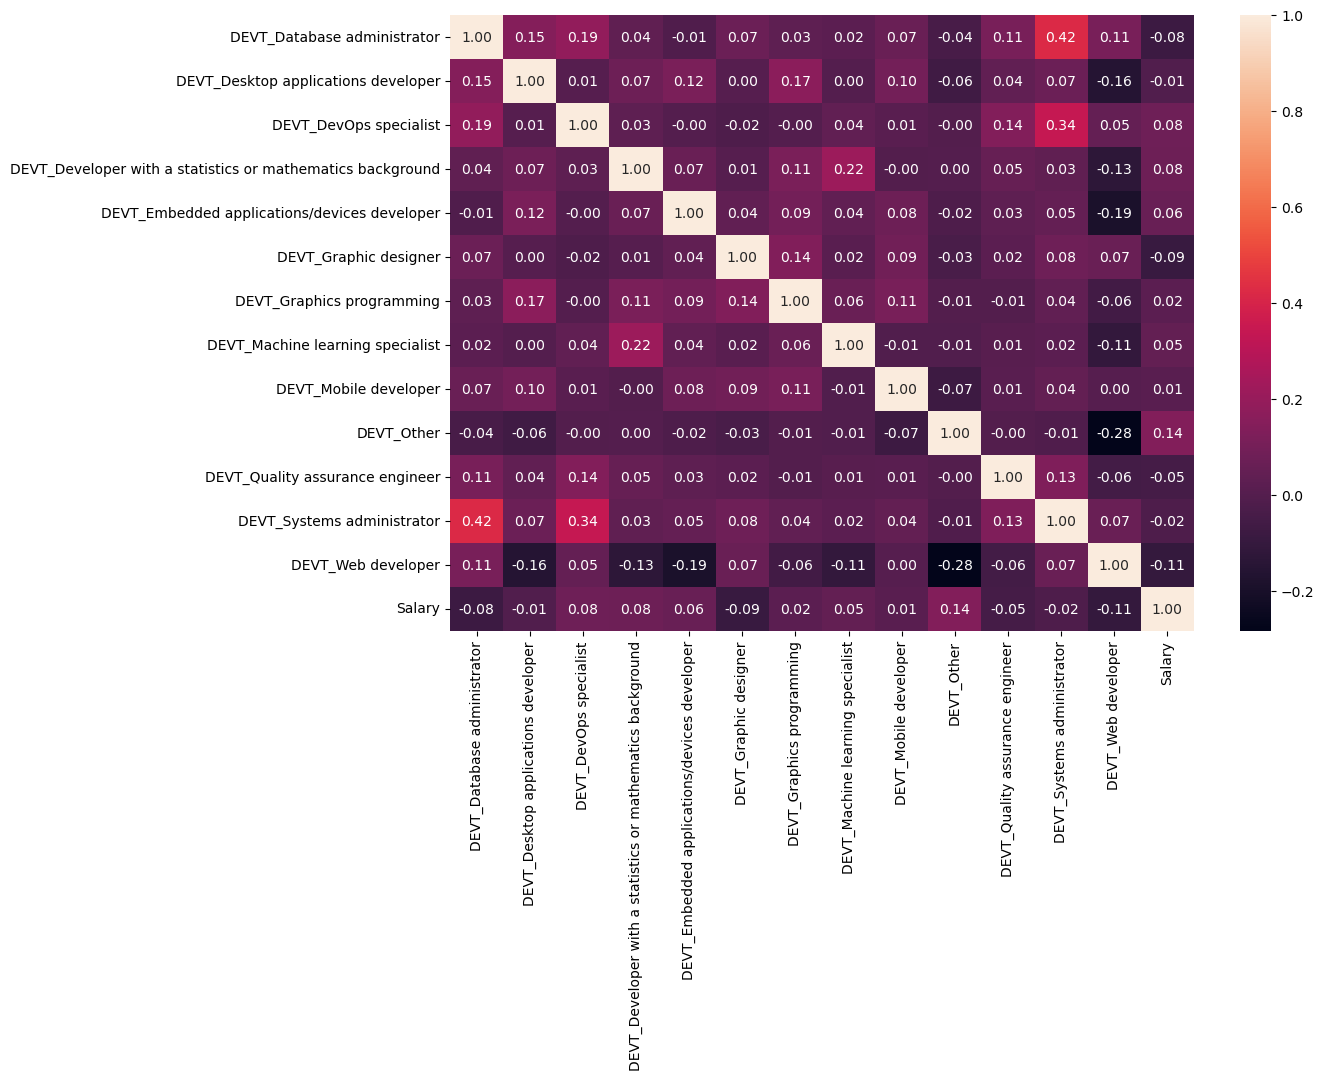

In [65]:
# Set the figure size
plt.figure(figsize=(12, 8)) 

sns.heatmap(df_red[['DEVT_Database administrator',
    'DEVT_Desktop applications developer', 'DEVT_DevOps specialist',
    'DEVT_Developer with a statistics or mathematics background',
    'DEVT_Embedded applications/devices developer',
    'DEVT_Graphic designer', 'DEVT_Graphics programming',
    'DEVT_Machine learning specialist', 'DEVT_Mobile developer',
    'DEVT_Other', 'DEVT_Quality assurance engineer',
    'DEVT_Systems administrator', 'DEVT_Web developer', 'Salary']].corr(), annot=True, fmt=".2f");

**Besides the correlation of DeveloperType-"Other" and Salary the strongest positive correlation is between DeveloperType-"Devoloper with a statistics or mathematics background" (+0.08) and Salary and "DevOps specialist" and Salary (+0.08)(+0.10).**

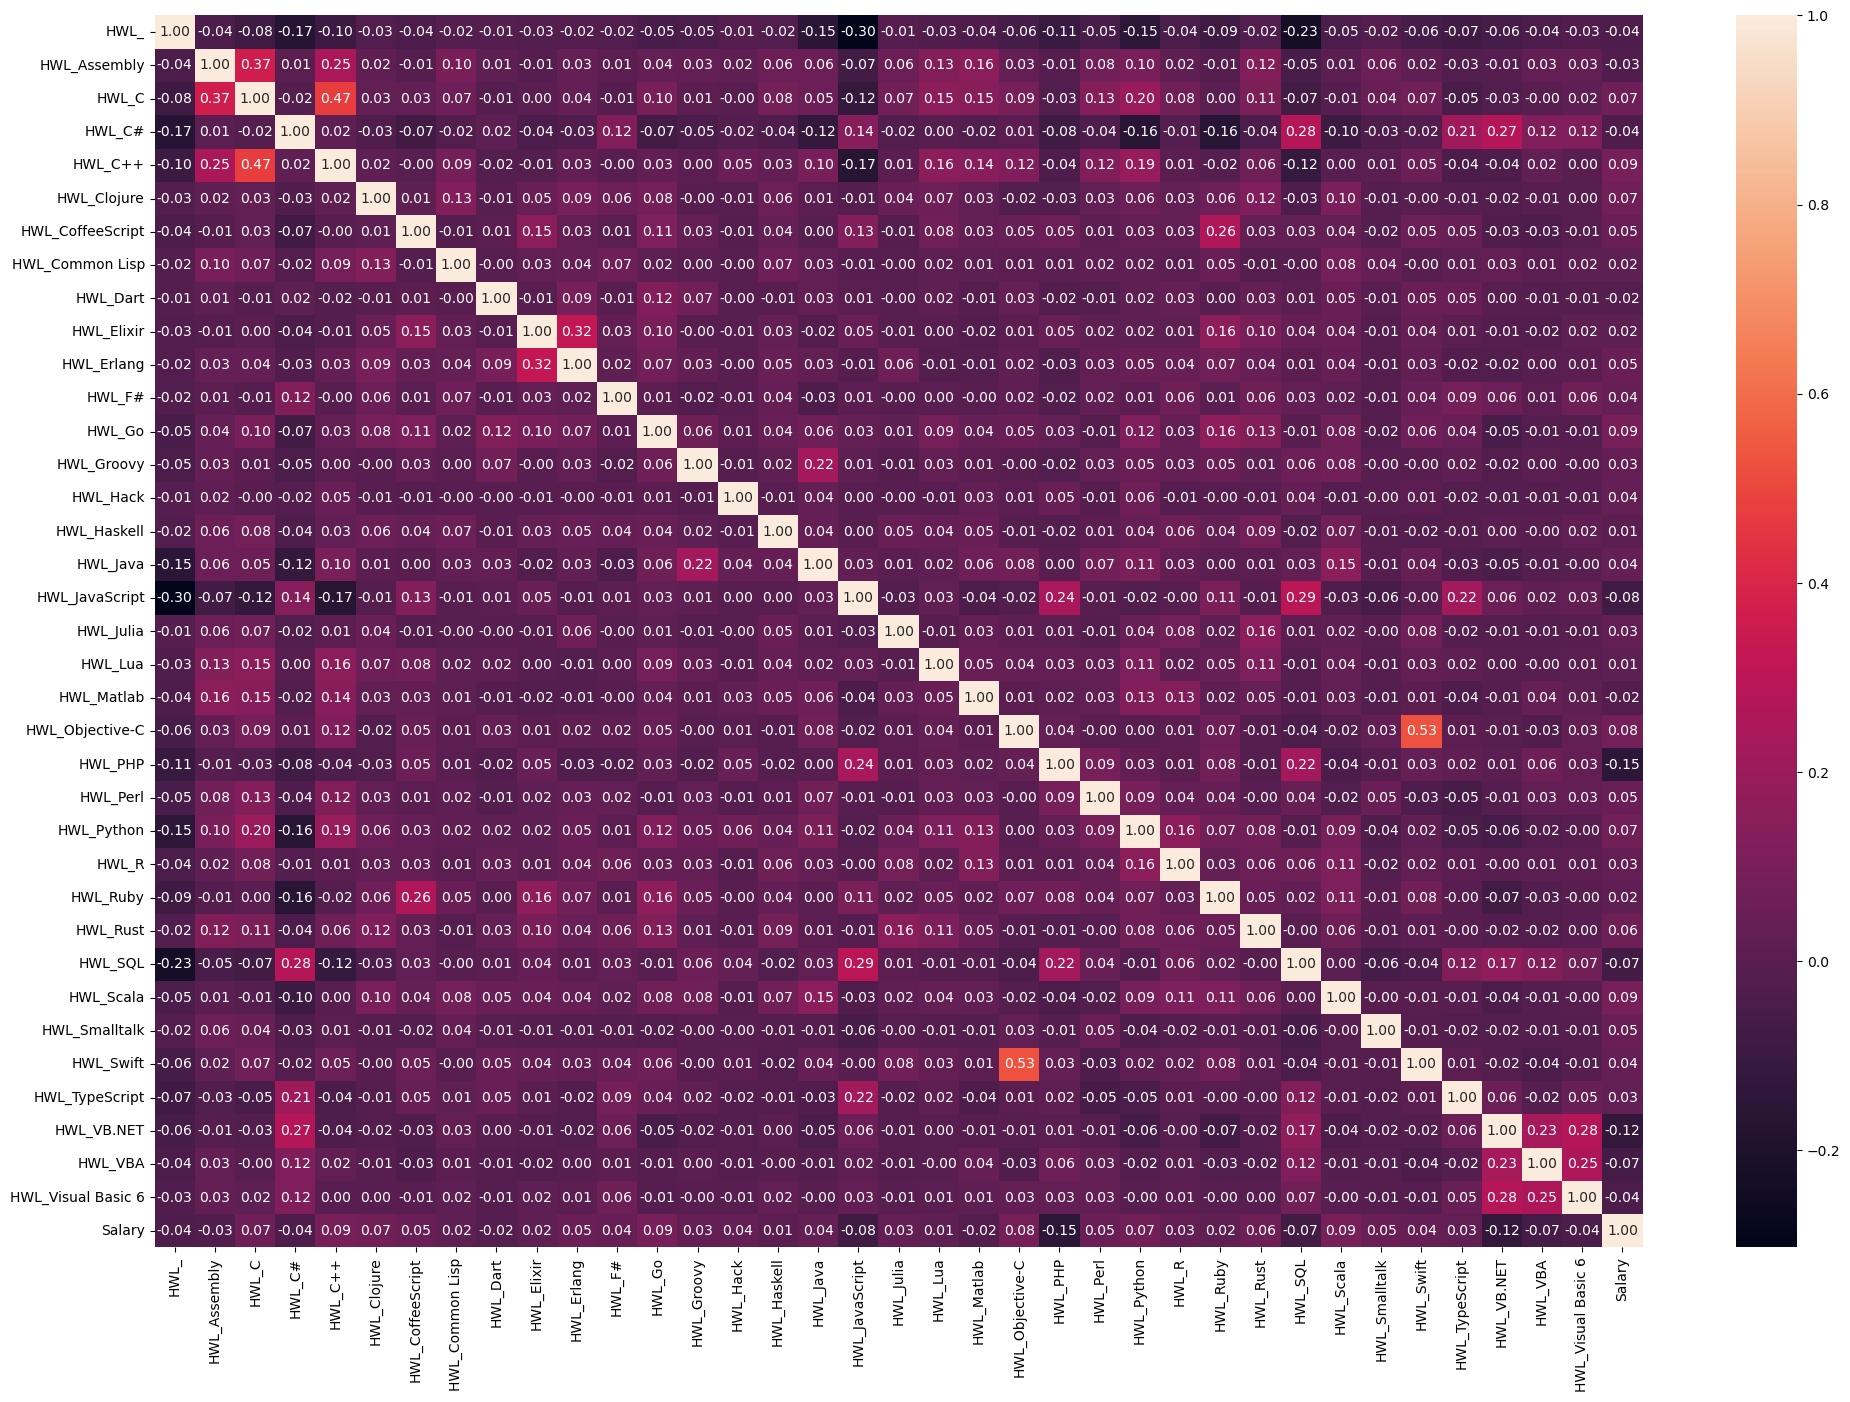

In [64]:
# Set the figure size
plt.figure(figsize=(24, 16)) 

sns.heatmap(df_red[['HWL_', 'HWL_Assembly', 'HWL_C', 'HWL_C#',
       'HWL_C++', 'HWL_Clojure', 'HWL_CoffeeScript', 'HWL_Common Lisp',
       'HWL_Dart', 'HWL_Elixir', 'HWL_Erlang', 'HWL_F#', 'HWL_Go',
       'HWL_Groovy', 'HWL_Hack', 'HWL_Haskell', 'HWL_Java',
       'HWL_JavaScript', 'HWL_Julia', 'HWL_Lua', 'HWL_Matlab',
       'HWL_Objective-C', 'HWL_PHP', 'HWL_Perl', 'HWL_Python', 'HWL_R',
       'HWL_Ruby', 'HWL_Rust', 'HWL_SQL', 'HWL_Scala', 'HWL_Smalltalk',
       'HWL_Swift', 'HWL_TypeScript', 'HWL_VB.NET', 'HWL_VBA',
       'HWL_Visual Basic 6', 'Salary']].corr(), annot=True, fmt=".2f");

**For HaveWorkLanguage the top 5 positive correlations to salary are C++, Go and Scala (+0.09), Objective-C (+0.08) then followed by Clojure and Python (+0.07).**

In [47]:
df_red_no_salary = df_red.drop(columns=['Salary', 'Respondent'])
ser_sal = df_red.Salary

In [48]:
ser_sal = df_red.Salary

In [49]:
df_red_no_salary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3684 entries, 17 to 51390
Columns: 108 entries, CareerSatisfaction to DEVT_Web developer
dtypes: Int64(1), bool(86), float64(4), int32(17)
memory usage: 859.4 KB


#### Impute the Missing Values

**By encoding the nominal/ordinal values some new missing values were generated which I am going to impute.**

In [50]:
imp = SimpleImputer(strategy='mean')
arr_red_no_salary = imp.fit_transform(df_red_no_salary)

#### Split the Data in Training and Test Sets

In [51]:
# Split the 'features' and 'salary' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(arr_red_no_salary, 
                                                    ser_sal, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 2947 samples.
Testing set has 737 samples.


### Model & Visualization

#### RandomForestRegressor
Random Forest Regressor:
If the target variable is continuous, the RandomForestRegressor can be a good choice. Random forests can handle non-linear relationships and are robust to overfitting, especially with a large number of features. They can also handle missing values in some implementations, but it's still a good practice to impute them.

Sensitivity to NaN: Random forests can handle NaN values in some implementations, but it's still advisable to preprocess your data to avoid potential issues. Imputation is a common practice before fitting the model.
Use Case: This model is robust to overfitting and can capture non-linear relationships well, making it a good choice for predicting continuous outcom

Data Requirements and Preprocessing:
* Nominal Data - OneHotEncoding required: DevoloperType, HaveWorkedLanguage
* Ordinal Data - OrdinalEncoder required: e. g. CompanySize, YearsProgram
* Missing Values - Imputation or deletion: required
* Feature Scaling - not mandatory

In [52]:
n_est = 300
results={}
results['n_est'] = n_est

rf_model = RandomForestRegressor(n_estimators=n_est)
rf_model.fit(X_train, y_train) 

RandomForestRegressor(n_estimators=300)

In [53]:
predictions_test = rf_model.predict(X_test)
predictions_train = rf_model.predict(X_train)

# Mean squared error on training samples
results['mse_train'] = mean_squared_error(y_train, predictions_train)
        
# Mean squared error on test samples
results['mse_test'] = mean_squared_error(y_test, predictions_test)
    
# r2 score on training samples
results['r2_train'] = r2_score(y_train, predictions_train)

# r2 score on testing samples
results['r2_test'] = r2_score(y_test, predictions_test)

In [54]:
print(results)

{'n_est': 300, 'mse_train': 0.002344297723053292, 'mse_test': 0.018485509577886087, 'r2_train': 0.922468647797032, 'r2_test': 0.38991179302003676}


**Interpretation:**
* **mse_train: low MSE, that means,  that predictions are close to actual values**
* **mse_test: higher than mse_train, model performs slightly worse on unseen data.**
* **r2_train: 92.3% of the variance of training data can be explained by the model, indicating a very good score for fitting training data.**
* **r2_test: 39.7% of the variance of test data can be explained, this is relatively low indicating the the model does not generalize well to unseen data. => overfitting?** 

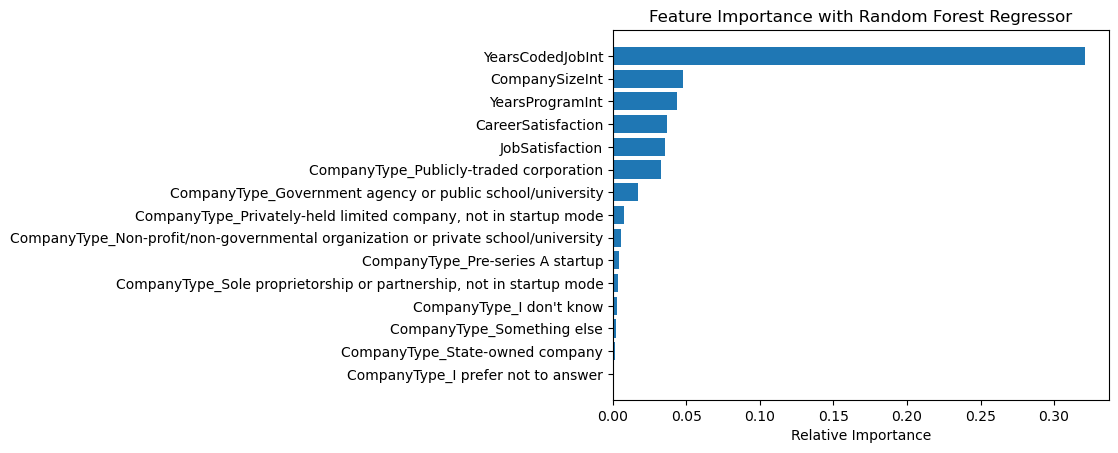

In [55]:
# Get feature importances
importances = rf_model.feature_importances_[:15,]

indices = range(len(importances))

# Rearrange feature names so they match the sorted feature importances
names = [df_red_no_salary.columns[i] for i in importances.argsort()]
 
# Plot Feature Importance
plt.figure()
plt.title('Feature Importance with Random Forest Regressor')
plt.barh(indices, sorted(importances), align='center')
plt.yticks(indices, names)
plt.xlabel('Relative Importance')
plt.show()

#### GradientBoostingRegressor
GradientBoostingRegressor:
Designed to predict a continuous target variable. Can handle complex relationships and interactions between features, including non-linear relationships. Robust to overfitting. 

Sensitivity to NaN: Can handle missing values.

Data Requirements and Preprocessing:
* Nominal Data - OneHotEncoding required: DevoloperType, HaveWorkedLanguage: done
* Ordinal Data - OrdinalEncoder required: CareerSatisfaction/JobSatisfaction - due to numerical scaling no further encoding necessary
* Missing Values - not a problem, no imputation/deletion required
* Feature Scaling - not mandatory

In [56]:
n_est = 123 
lr = 0.075
md = 4
results={}
results['n_est'] = n_est
results['lr'] = lr
results['md'] = md


# Instantiate the Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(n_estimators=n_est, learning_rate=lr, max_depth=md, random_state=42)

# Fit the model on the training data
gbr_model.fit(X_train, y_train)

# Make predictions on the training and test sets
predictions_train = gbr_model.predict(X_train)
predictions_test = gbr_model.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, predictions_train)
mse_test = mean_squared_error(y_test, predictions_test)
r2_train = r2_score(y_train, predictions_train)
r2_test = r2_score(y_test, predictions_test)

# Mean squared error on training samples
results['mse_train'] = mean_squared_error(y_train, predictions_train)
        
# Mean squared error on test samples
results['mse_test'] = mean_squared_error(y_test, predictions_test)
    
# r2 score on training samples
results['r2_train'] = r2_score(y_train, predictions_train)

# r2 score on testing samples
results['r2_test'] = r2_score(y_test, predictions_test)

print(results)

{'n_est': 123, 'lr': 0.075, 'md': 4, 'mse_train': 0.011190624309368184, 'mse_test': 0.01690891679387999, 'r2_train': 0.6299001504080731, 'r2_test': 0.44194501724245616}


**Interpretation:**
* **mse_train: low MSE, that means,  that predictions are close to actual values**
* **mse_test: slightly higher than mse_train, showing that this model performs positively.**
* **r2_train: 63.0% of the variance of training data can be explained by the model, indicating a fair score for fitting training data, which coudl be improved by more tuning.**
* **r2_test: 44.2% of the variance of test data can be explained, the model performs reasonably well** 

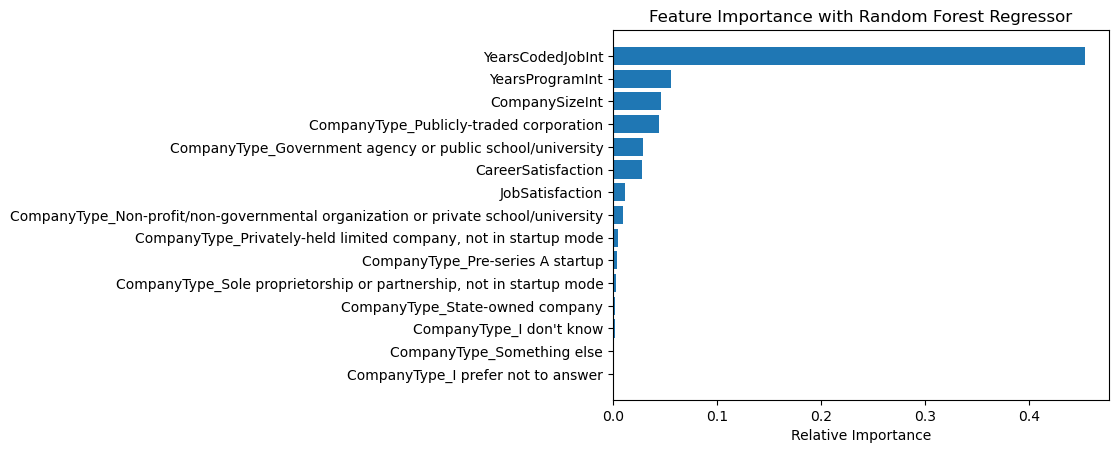

In [57]:
# Get feature importances
importances = gbr_model.feature_importances_[:15,]

indices = range(len(importances))

# Rearrange feature names so they match the sorted feature importances
names = [df_red_no_salary.columns[i] for i in importances.argsort()]
 
# Plot Feature Importance
plt.figure()
plt.title('Feature Importance with Random Forest Regressor')
plt.barh(indices, sorted(importances), align='center')
plt.yticks(indices, names)
plt.xlabel('Relative Importance')
plt.show()

**Interpreation of Feature Importance**
**The main determining features on Salary for US respondents, being professional developers either full-time or self-employed is the Years of Coding experience as part of the job. Then, with large distance, the number of years since coding was learnd and the company size are determinating the salary. Very important is also the CompanyType property, as it is 10 time in the top 15 determinants. CareerSatisfaction and JobSatisfaction are the top 6/7 determinants.**

#### LinearRegression
LinearRegression:
Designed to predict a continuous target variable. Linear relationships between the features and the targ variable and for low-dimensional data. Easy to interpret. Independence of features.

Sensitivity to NaN: Cannot handle missing values.

Data Requirements and Preprocessing:
* Nominal Data - OneHotEncoding required: DevoloperType, HaveWorkedLanguage: done
* Ordinal Data - OrdinalEncoder required: CareerSatisfaction/JobSatisfaction - due to numerical scaling no further encoding necessary
* Missing Values - cannot handle, imputation/deletion required
* Feature Scaling - required if features have different units/scales 


In [58]:
#Instantiate
lr_model = LinearRegression() 

#Fit - why does this break?
lr_model.fit(X_train, y_train) 

LinearRegression()

In [59]:
results={}

predictions_test = lr_model.predict(X_test)
predictions_train = lr_model.predict(X_train)

# Mean squared error on training samples
results['mse_train'] = mean_squared_error(y_train, predictions_train)
        
# Mean squared error on test samples
results['mse_test'] = mean_squared_error(y_test, predictions_test)
    
# r2 score on training samples
results['r2_train'] = r2_score(y_train, predictions_train)

# r2 score on testing samples
results['r2_test'] = r2_score(y_test, predictions_test)

In [60]:
print(results)

{'mse_train': 0.016049789941161696, 'mse_test': 0.018007754062395052, 'r2_train': 0.4691962951313362, 'r2_test': 0.4056794408953974}
